In [1]:
import torch
from torch import nn
import torchmetrics
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [2]:
# Creating data using the make_moons function
NUM_SAMPLES = 1000
RANDOM_SEED = 42

X, y = make_moons(n_samples=NUM_SAMPLES, noise=0.07, random_state=RANDOM_SEED)
X[:10], y[:10]

(array([[-0.03341062,  0.4213911 ],
        [ 0.99882703, -0.4428903 ],
        [ 0.88959204, -0.32784256],
        [ 0.34195829, -0.41768975],
        [-0.83853099,  0.53237483],
        [ 0.59906425, -0.28977331],
        [ 0.29009023, -0.2046885 ],
        [-0.03826868,  0.45942924],
        [ 1.61377123, -0.2939697 ],
        [ 0.693337  ,  0.82781911]]),
 array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0], dtype=int64))

In [3]:
# Convert data into pandas dataframe
data_df = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "y": y})
data_df.head(7)

,X1,X2,y
0,-0.033411,0.421391,1
1,0.998827,-0.442890,1
2,0.889592,-0.327843,1
3,0.341958,-0.417690,1
4,-0.838531,0.532375,0
5,0.599064,-0.289773,1
6,0.290090,-0.204688,1


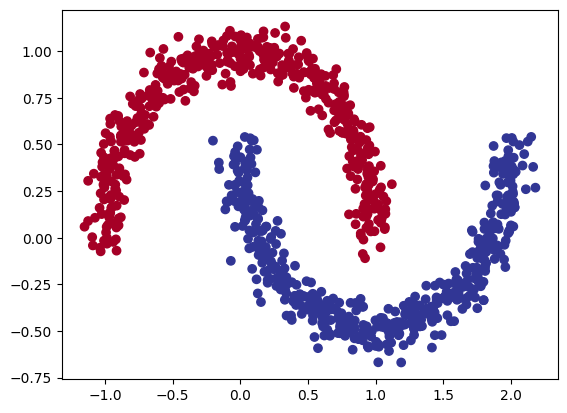

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [5]:
# Convert the data into PyTorch tensors
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

In [7]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=RANDOM_SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
# Creating a binary classification model using PyTorch
class MoonModel(nn.Module):
    def __init__(self, in_features, out_features, hidden_units):
        super().__init__()

        self.layer1 = nn.Linear(in_features=in_features, out_features=hidden_units)
        self.layer2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units, out_features=out_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))
    
MNet = MoonModel(in_features=2, out_features=1, hidden_units=10).to(device)
MNet

MoonModel(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [12]:
MNet.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.6124, -0.5576],
                      [-0.4093, -0.6454],
                      [-0.3476,  0.0921],
                      [-0.5154,  0.5556],
                      [ 0.2353, -0.1750],
                      [-0.1874,  0.4791],
                      [-0.3018, -0.1435],
                      [ 0.6576,  0.6942],
                      [-0.3553,  0.4921],
                      [ 0.6596,  0.2956]], device='cuda:0')),
             ('layer1.bias',
              tensor([ 0.1532,  0.3661, -0.0093,  0.1179, -0.2045, -0.6173,  0.0177, -0.3977,
                       0.4973, -0.1378], device='cuda:0')),
             ('layer2.weight',
              tensor([[-0.1963, -0.1497,  0.0982,  0.2018,  0.1352, -0.0883, -0.0740,  0.0175,
                        0.2039, -0.1047],
                      [-0.2737, -0.0709,  0.0924, -0.1761, -0.1549,  0.3076, -0.2081, -0.1543,
                        0.2968,  0.3049],
                      [-0.0302,  0.2659, 

In [13]:
# Set up the loss function, optimizer and the accuracy
loss_fn = nn.BCEWithLogitsLoss() # Sigmoid activation is built-in
optimizer = torch.optim.SGD(params=MNet.parameters(), lr=0.1)
acc_fn = torchmetrics.Accuracy(task="multiclass", num_classes=2).to(device)

In [14]:
# Put the data to target device(gpu here)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [16]:
# Training the model
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

epochs = 1000

for epoch in range(epochs):
    MNet.train()
    y_logits = MNet(X_train).squeeze()
    y_pred_probs = torch.sigmoid(y_logits)
    y_pred = torch.round(y_pred_probs)

    loss = loss_fn(y_logits, y_train)
    acc = acc_fn(y_pred, y_train.int())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    MNet.eval()
    with torch.inference_mode():
        test_logits = MNet(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn(test_pred, y_test.int())

    if (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch + 1} | Loss: {loss: .4f} Acc: {acc: .2f} | Test loss: {test_loss: .4f} Test acc: {test_acc: .2f}")



Epoch: 100 | Loss:  0.3210 Acc:  0.85 | Test loss:  0.3319 Test acc:  0.83
Epoch: 200 | Loss:  0.2356 Acc:  0.89 | Test loss:  0.2334 Test acc:  0.90
Epoch: 300 | Loss:  0.2091 Acc:  0.91 | Test loss:  0.2036 Test acc:  0.91
Epoch: 400 | Loss:  0.1805 Acc:  0.93 | Test loss:  0.1740 Test acc:  0.92
Epoch: 500 | Loss:  0.1409 Acc:  0.94 | Test loss:  0.1347 Test acc:  0.94
Epoch: 600 | Loss:  0.0978 Acc:  0.96 | Test loss:  0.0915 Test acc:  0.98
Epoch: 700 | Loss:  0.0628 Acc:  0.99 | Test loss:  0.0575 Test acc:  0.99
Epoch: 800 | Loss:  0.0411 Acc:  1.00 | Test loss:  0.0369 Test acc:  1.00
Epoch: 900 | Loss:  0.0288 Acc:  1.00 | Test loss:  0.0253 Test acc:  1.00
Epoch: 1000 | Loss:  0.0215 Acc:  1.00 | Test loss:  0.0185 Test acc:  1.00


In [17]:
# Make Predictions
MNet.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(MNet(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

In [18]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

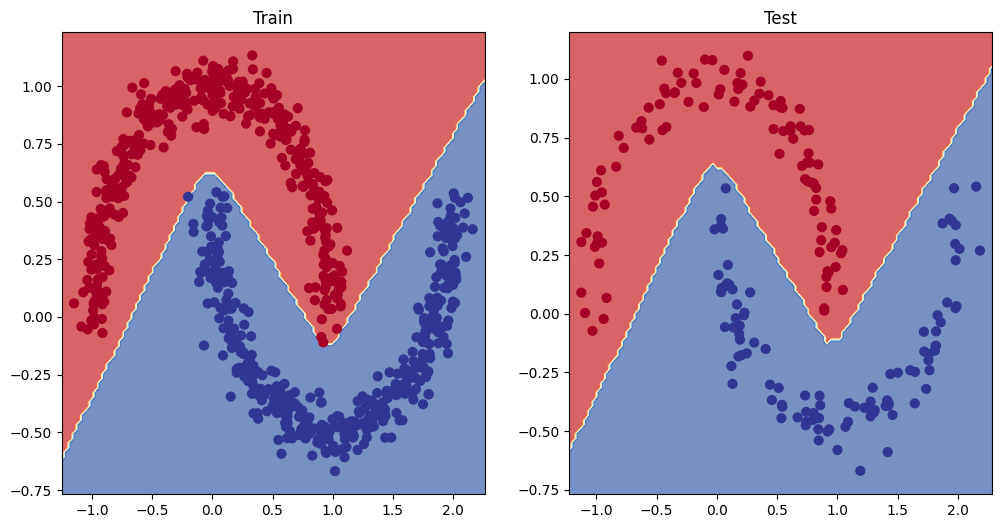

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(MNet, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(MNet, X_test, y_test)